In [1]:
import pandas as pd
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt

In [2]:
# Подключение к базе данных
db_path = 'chinook.db'
try:
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    print("База подключена!")
except sqlite3.Error as e:
    print("Ошибка при подключении к базе данных:", e)

База подключена!


In [60]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
tables = cursor.fetchall()

if tables:
    print("Таблицы базы данных:")
    for table in tables:
        print(table[0])
else:
    print("В базе данных таблиц не найдено.")

Таблицы базы данных:
album
artist
customer
employee
genre
invoice
invoice_line
media_type
playlist
playlist_track
track


Напишите запрос, в результате которого получится таблица, содержащая:
данные о чеках (invoice): id, дату;
id покупателя и id всех треков в чеке;
жанр каждого трека: объедините все тяжёлые жанры (Rock, Alternative & Punk, Metal, Alternative, Heavy Metal) в категорию ‘rock’, а остальные жанры — в категорию ‘others’;
стоимость трека.
В таблицу должны попасть данные только по аудиофайлам (нужно проверить media_type) и только за 2020 год. Запрос будет содержать несколько джойнов.

In [11]:
# Запрос для получения данны
query= """
    SELECT
      i.invoice_id,
      i.invoice_date,
      i.customer_id,
      t.track_id,
      CASE
            WHEN g.name IN ('Rock', 'Alternative & Punk', 'Metal', 'Alternative', 'Heavy Metal') THEN 'rock'
            ELSE 'others'
        END AS genre_category,
        t.unit_price
    FROM invoice as i
    JOIN invoice_line il ON i.invoice_id = il.invoice_id
    JOIN track t ON il.track_id = t.track_id
    JOIN genre g ON t.genre_id = g.genre_id
    WHERE t.media_type_id = 1  -- Аудиофайлы
        AND strftime('%Y', i.invoice_date) = '2020'  -- Только за 2020 год
"""

На основе запроса создайте датафрейм с помощью read_sql_query в pandas.

In [15]:
# Создание датафрейма
df = pd.read_sql_query(query, conn)
df.head()

,invoice_id,invoice_date,customer_id,track_id,genre_category,unit_price
0,496,2020-04-01 00:00:00,21,1,rock,0.99
1,496,2020-04-01 00:00:00,21,6,rock,0.99
2,525,2020-06-02 00:00:00,30,6,rock,0.99
3,569,2020-10-06 00:00:00,47,6,rock,0.99
4,496,2020-04-01 00:00:00,21,8,rock,0.99


In [21]:
df.shape

(1023, 6)

Проверьте датафрейм на пропуски и дубликаты. Если они есть, предположите их происхождение и решите, нужно ли их обрабатывать.

In [19]:
# Проверка на пропуски и дубликаты
print("Пропуски в данных:")
print(df.isnull().sum())
print("\nДубликаты:")
print(df.duplicated().sum())

Пропуски в данных:
invoice_id        0
invoice_date      0
customer_id       0
track_id          0
genre_category    0
unit_price        0
dtype: int64

Дубликаты:
2


In [22]:
df.drop_duplicates()

,invoice_id,invoice_date,customer_id,track_id,genre_category,unit_price
0,496,2020-04-01 00:00:00,21,1,rock,0.99
1,496,2020-04-01 00:00:00,21,6,rock,0.99
2,525,2020-06-02 00:00:00,30,6,rock,0.99
3,569,2020-10-06 00:00:00,47,6,rock,0.99
4,496,2020-04-01 00:00:00,21,8,rock,0.99
...,...,...,...,...,...,...
1018,559,2020-09-11 00:00:00,32,3304,others,0.99
1019,520,2020-05-26 00:00:00,5,3308,others,0.99
1020,577,2020-10-20 00:00:00,28,3310,others,0.99
1021,557,2020-09-08 00:00:00,2,3327,others,0.99


Приведите дату к первому числу каждого месяца (2020-01-01, 2020-02-01 и так далее).

In [23]:
# Приведение даты к первому числу месяца
df['invoice_month'] = pd.to_datetime(df['invoice_date']).dt.to_period('M').dt.to_timestamp()
df.head()

,invoice_id,invoice_date,customer_id,track_id,genre_category,unit_price,invoice_month
0,496,2020-04-01 00:00:00,21,1,rock,0.99,2020-04-01
1,496,2020-04-01 00:00:00,21,6,rock,0.99,2020-04-01
2,525,2020-06-02 00:00:00,30,6,rock,0.99,2020-06-01
3,569,2020-10-06 00:00:00,47,6,rock,0.99,2020-10-01
4,496,2020-04-01 00:00:00,21,8,rock,0.99,2020-04-01


Сгруппируйте данные и с помощью библиотеки seaborn. Постройте графики, чтобы оценить по категориям жанров (‘rock’ и ‘others’) следующие ежемесячные показатели:

общее количество купленных треков,

число чеков,

число покупателей,

общую стоимость треков.

Должно получиться три графика, где на каждом присутствуют обе категории и ежемесячные показатели по ним.

In [29]:
# Группировка данных
grouped_df = df.groupby(['invoice_month', 'genre_category']).agg({
    'track_id': 'count',#общее количество купленных треков
    'invoice_id': 'nunique',#число чеков
    'customer_id': 'nunique',#число покупателей
    'unit_price': 'sum'#общую стоимость треков
}).reset_index()
grouped_df

,invoice_month,genre_category,track_id,invoice_id,customer_id,unit_price
0,2020-01-01,others,4,2,2,3.96
1,2020-01-01,rock,38,8,8,37.62
2,2020-02-01,others,5,4,4,4.95
3,2020-02-01,rock,87,11,11,86.13
4,2020-03-01,others,20,6,6,19.80
5,2020-03-01,rock,46,9,9,45.54
6,2020-04-01,others,12,7,7,11.88
7,2020-04-01,rock,103,15,15,101.97
8,2020-05-01,others,13,7,7,12.87
9,2020-05-01,rock,64,13,11,63.36


In [51]:
sns.set(style="whitegrid")

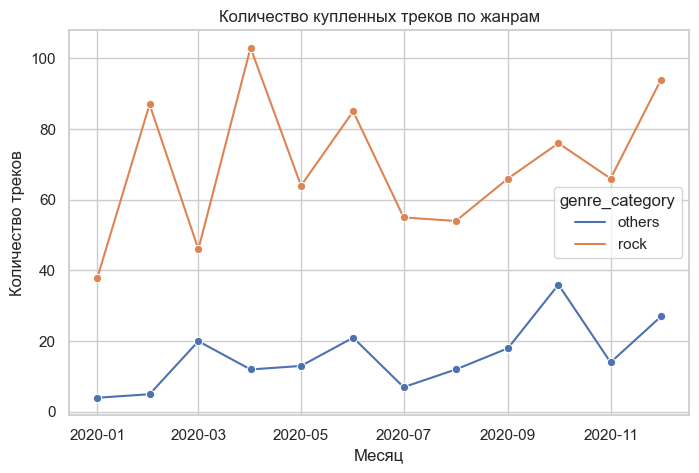

In [52]:
plt.figure(figsize=(8,5))
sns.lineplot(x='invoice_month', y='track_id', hue='genre_category', data=grouped_df, marker='o')
plt.title("Количество купленных треков по жанрам")
plt.xlabel("Месяц")
plt.ylabel("Количество треков")
plt.show()

Вывод: Количество купленных треков в жанре "rock" всегда превышало количество купленных треков в жанре "others". Для обоих жанров меньше всего треков было куплено в январе.Месяц максиламьных продаж для треков в жанре "rock" - апрель, а для треков в жанре "others" - октябрь. 

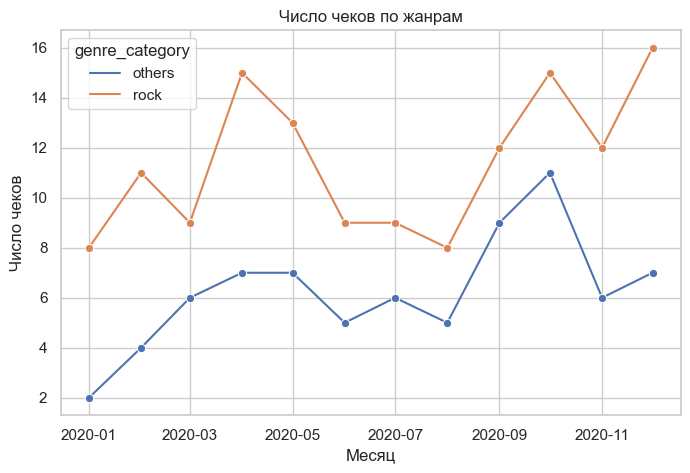

In [57]:
plt.figure(figsize=(8,5))
sns.lineplot(x='invoice_month', y='invoice_id', hue='genre_category', data=grouped_df, marker='o')
plt.title("Число чеков по жанрам")
plt.xlabel("Месяц")
plt.ylabel("Число чеков")
plt.show()

Вывод: Количество чеков в жанре "rock" в каждом месяце превышало количество чеков в жанре "others". Для обоих жанров меньше всего чеков было в январе. В жанре "rock" вторым минимумом также стал август. Месяц с максимальным количеством чеков для треков в жанре "rock" - декабрь, а для треков в жанре "others" - октябрь. 

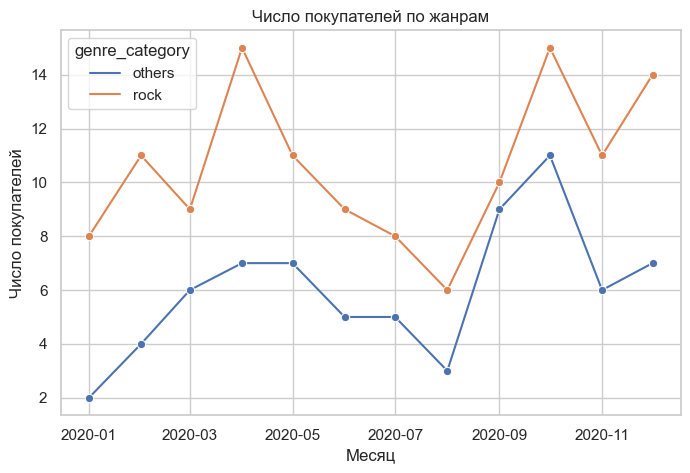

In [58]:
plt.figure(figsize=(8,5))
sns.lineplot(x='invoice_month', y='customer_id', hue='genre_category', data=grouped_df, marker='o')
plt.title("Число покупателей по жанрам")
plt.xlabel("Месяц")
plt.ylabel("Число покупателей")
plt.show()

Вывод: Количество покупателей в жанре "rock" в каждом месяце превышало количество покупателей в жанре "others". Для жанра "rock" месяцем с минимальным количеством покупателей был август, а для жанра "others" - январь. Месяц с максимальным количеством покупателей для треков в жанре "rock" - апрель и октябрь, а для треков в жанре "others" - октябрь. 

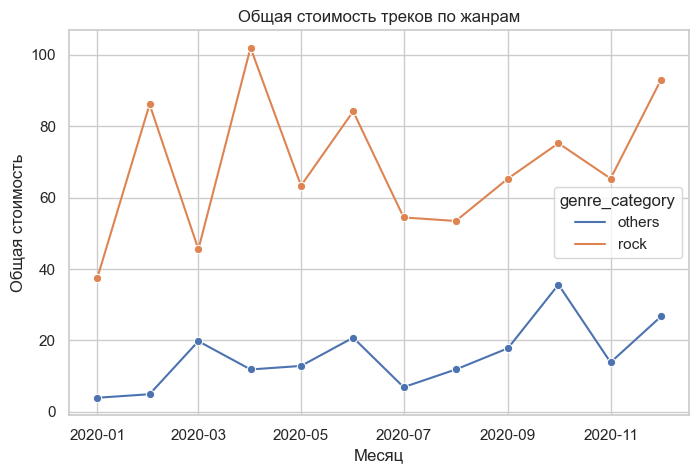

In [59]:
plt.figure(figsize=(8,5))
sns.lineplot(x='invoice_month', y='unit_price', hue='genre_category', data=grouped_df, marker='o')
plt.title("Общая стоимость треков по жанрам")
plt.xlabel("Месяц")
plt.ylabel("Общая стоимость")
plt.show()

Вывод: Максимальная общая стоимость треков в жанре "rock" в каждом месяце превышала максимальную общую стоимость треков в жанре "others". Для обоих жанров месяцем с минимальной общей стоимостью треков был январь. Месяц с максимальной общей стоимостью треков для треков в жанре "rock" - апрель, а для треков в жанре "others" - октябрь. 

В целом можно отметить, что для обеих групп январь является месяцем с низкими показателями, а в апреле и октябре ситуация на порядок лучше. Также на всех графиках наблюдается спад в ноябре, по сравнению с октябрем, и рост в декабре, по сравнению с ноябрем, а также рост в феврале, по сравкнению с январем.